<IPython.core.display.Javascript object>


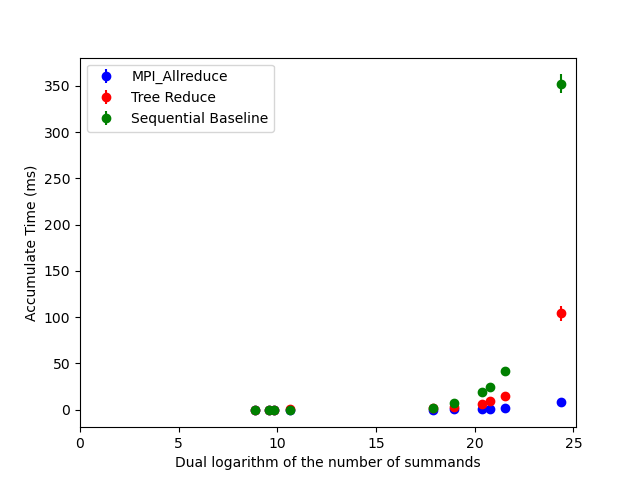

In [48]:
%matplotlib notebook
import sqlite3
import matplotlib.pyplot as plt
import numpy as np

# warning: not safe from SQL injection
def fetch_data(cluster_size, mode):
    con = sqlite3.connect('file:results.db?mode=ro', uri=True)
    cur = con.cursor()
    
    cur.execute(f"SELECT n_summands, datafile, time_ns / 1e6, stddev / 1e6 FROM results WHERE mode = ? AND cluster_size = ?",
               (mode, cluster_size))


    a = cur.fetchall()
    con.close()
    return a

def xye(data):
    x = np.log2(list(map(lambda x: x[0], data))) # n_summands
    y = list(map(lambda x: x[2], data)) # time_ns
    e = list(map(lambda x: x[3], data)) # stddev
    return x, y, e


ar_x, ar_y, ar_error = xye(fetch_data(8, 'allreduce'))
t_x, t_y, t_error = xye(fetch_data(8, 'tree'))
b_x, b_y, b_error = xye(fetch_data(8, 'baseline'))

f = plt.figure()
ax = f.subplots(1)
ax.set_ylabel('Accumulate Time (ms)')
ax.set_xlabel('Dual logarithm of the number of summands')

ax.errorbar(ar_x, ar_y, yerr=ar_error, fmt='bo', label='MPI_Allreduce')
ax.errorbar(t_x, t_y, yerr=t_error, fmt='ro', label='Tree Reduce')
ax.errorbar(b_x, b_y, yerr=b_error, fmt='go', label='Sequential Baseline')

ax.legend(loc='upper left')

ax.set_xlim(left=0)
#ax.set_ylim(bottom=0)

plt.show()
plt.savefig(fname="figure.svg")